# Baseline Pipeline: EDA → Modeling → Submission

This notebook outlines a baseline workflow for the RSNA intracranial aneurysm detection challenge,
including comprehensive exploratory data analysis (EDA), demographic-based baseline modeling
with hyperparameter tuning, and submission generation.

In [1]:
import os
import shutil
from collections import defaultdict

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

import pydicom
import tempfile
import kaggle_evaluation.rsna_inference_server as rsna_server # Inference server

SEED = 42

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.filterwarnings("ignore", message="Glyph.*missing from current font")
warnings.filterwarnings("ignore", message="invalid value encountered in less")

from polars.exceptions import DataOrientationWarning
warnings.filterwarnings("ignore", category=DataOrientationWarning)

# Input directory for Kaggle competition
DATA_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/'

## 2. Load Data

In [2]:
# Load training labels and localizer metadata
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train_localizers = pd.read_csv(os.path.join(DATA_PATH, 'train_localizers.csv'))

print(f"Number of training series: {train_df.shape[0]}")
print(f"Number of localization rows: {train_localizers.shape[0]}")

Number of training series: 4348
Number of localization rows: 2254


## 3. Exploratory Data Analysis (EDA)

In [3]:
def plot_age_distribution(data, column='PatientAge', title='RSNA Train Data'):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[4, 1])

    # Histogram
    sns.histplot(data[column], bins=30, kde=True, color='#3498db', ax=axes[0])
    axes[0].set_title(f"{title} — {column}", fontsize=11, fontweight='bold')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Count")

    # Boxplot
    sns.boxplot(x=data[column], color='#f39c12', ax=axes[1])
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

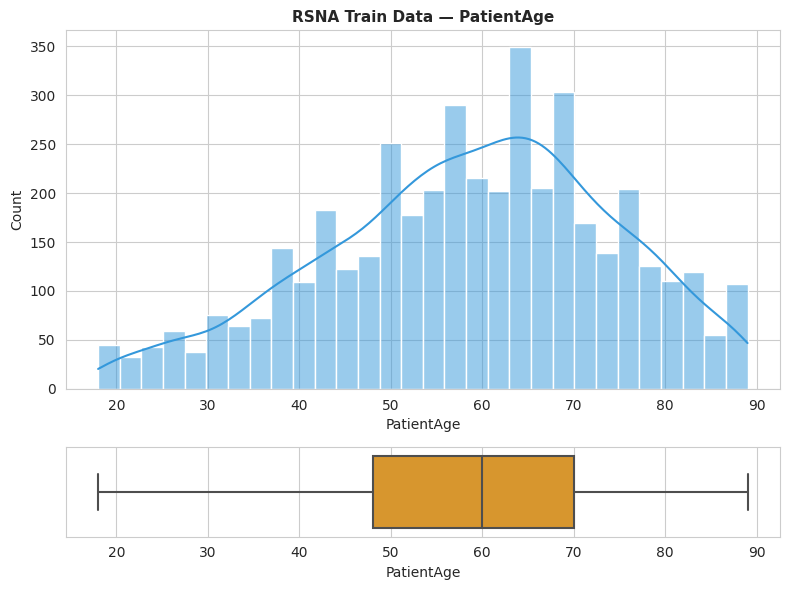

In [4]:
plot_age_distribution(train_df)

In [5]:
def plot_sex_distribution(data, column='PatientSex', title='Patient Sex Distribution'):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=column, palette='pastel')
    plt.title(title)
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.show()

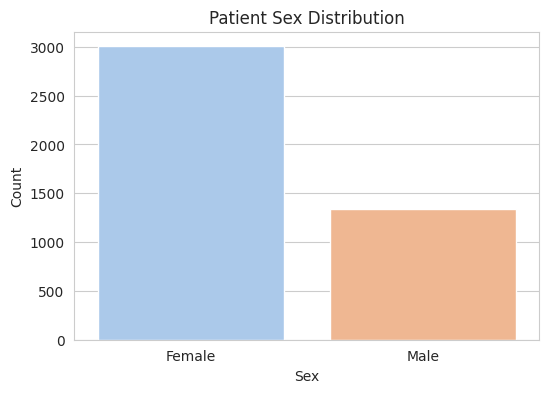

In [6]:
plot_sex_distribution(train_df)

In [7]:
def plot_age_vs_aneurysm(data, age_col='PatientAge', target_col='Aneurysm Present', title='Age vs. Aneurysm Presence'):
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data, x=target_col, y=age_col, palette='pastel')
    plt.xticks([0, 1], ['Absent', 'Present'])
    plt.title(title)
    plt.xlabel('Aneurysm Presence')
    plt.ylabel('Age')
    plt.show()

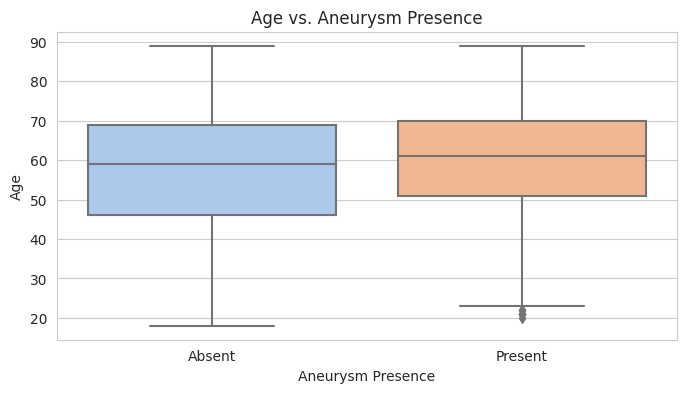

In [8]:
plot_age_vs_aneurysm(train_df)

In [9]:
def plot_modality_distribution(data, column='Modality', title='Imaging Modality Distribution'):
    plt.figure(figsize=(6, 6))
    counts = data[column].value_counts()
    plt.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('Set2', n_colors=len(counts))
    )
    plt.title(title)
    plt.show()

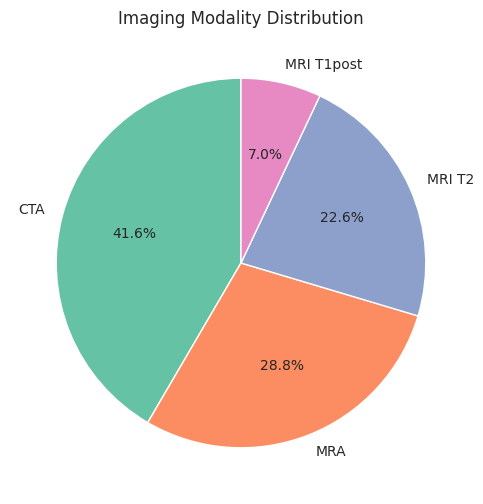

In [10]:
plot_modality_distribution(train_df)

In [11]:
def plot_aneurysm_prevalence_by_modality(data, modality_col='Modality', target_col='Aneurysm Present', title='Aneurysm Prevalence by Modality'):
    # Calculate mean prevalence per modality
    modality_rates = data.groupby(modality_col)[target_col].mean()

    plt.figure(figsize=(6, 6))
    plt.pie(
        modality_rates,
        labels=modality_rates.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('Set1', n_colors=len(modality_rates))
    )
    plt.title(title)
    plt.show()

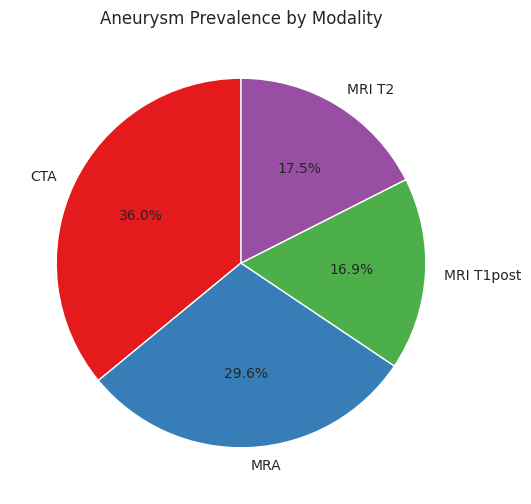

In [12]:
plot_aneurysm_prevalence_by_modality(train_df)

In [13]:
def plot_label_prevalence_pie(data, label_cols, title='Aneurysm Prevalence by Vascular Location'):
    # Calculate mean prevalence per label (i.e., proportion of aneurysm presence)
    prevalences = data[label_cols].mean().sort_values(ascending=False)

    plt.figure(figsize=(8, 8))
    plt.pie(
        prevalences,
        labels=prevalences.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('coolwarm', n_colors=len(prevalences))
    )
    plt.title(title)
    plt.show()

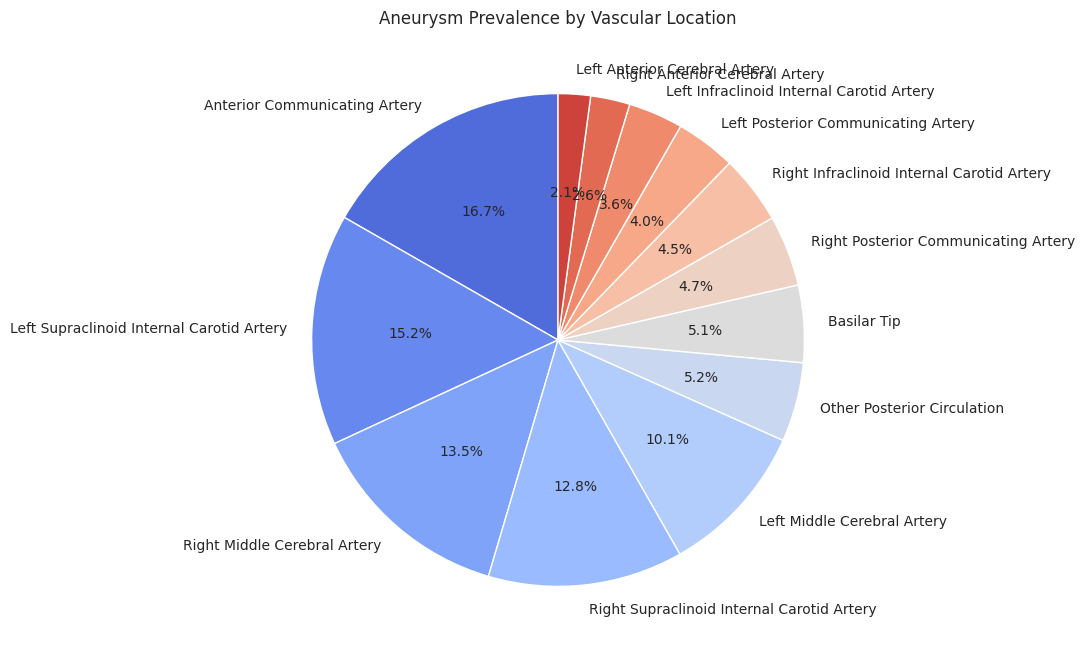

In [14]:
label_cols = [
    'Left Infraclinoid Internal Carotid Artery','Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery','Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery','Right Middle Cerebral Artery','Anterior Communicating Artery',
    'Left Anterior Cerebral Artery','Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery','Right Posterior Communicating Artery',
    'Basilar Tip','Other Posterior Circulation'
]

plot_label_prevalence_pie(train_df, label_cols)

In [15]:
def plot_label_correlation_heatmap(
    data, 
    label_cols, 
    target_col='Aneurysm Present', 
    title='Correlation Matrix of Aneurysm Labels'
):
    # Compute correlation matrix
    cor_mat = data[label_cols + [target_col]].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cor_mat,
        annot=True,
        fmt=".2f",
        cmap='YlGnBu',            # light & bright palette
        center=0,
        square=False,
        linewidths=0.4,
        annot_kws={"size": 7},
        cbar_kws={'label': 'Correlation'}
    )
    plt.title(title, fontsize=11, fontweight='bold', pad=8)
    plt.xticks(rotation=40, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

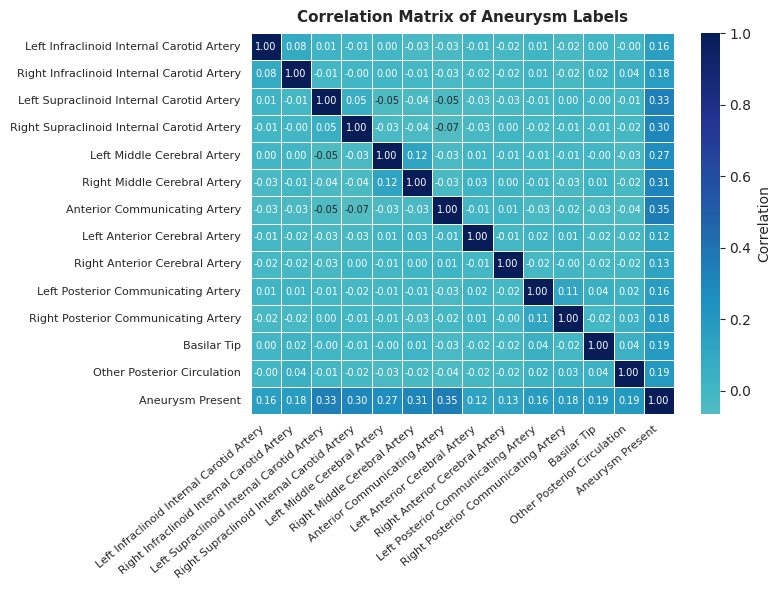

In [16]:
plot_label_correlation_heatmap(train_df, label_cols)

## 4. Preprocessing & Feature Engineering
We will build a simple demographic-based baseline: numeric age, sex, and one-hot encoded modality.

In [17]:
df_age = train_df['PatientAge'].astype(str)

In [18]:
# Features
X = pd.DataFrame({
    "age": train_df["PatientAge"].astype(float),
    "sex": train_df["PatientSex"].map({"Male": 1, "Female": -1})   # Male=1, Female=-1
}).join(pd.get_dummies(train_df["Modality"], prefix="mod"))

# Target
y = train_df["Aneurysm Present"].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(X.head(3))

Feature matrix shape: (4348, 6)
    age  sex  mod_CTA  mod_MRA  mod_MRI T1post  mod_MRI T2
0  64.0   -1    False     True           False       False
1  76.0   -1    False     True           False       False
2  58.0    1     True    False           False       False


## 5. train_df/Test Split & Hyperparameter Tuning

In [19]:
# 5.1 split into train_df and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# 5.2 initialize and fit Gradient Boosting model
gbm = GradientBoostingClassifier(
    n_estimators=100,     # number of trees
    learning_rate=0.1,    # shrinkage factor
    max_depth=8,          # maximum tree depth
    random_state=SEED
)
gbm.fit(X_train, y_train)

# 5.3 evaluate on validation set
val_probs = gbm.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"GBM Validation AUC: {val_auc:.4f}")

GBM Validation AUC: 0.6389


## 6. Inference & Submission

In [20]:
# 6.1 Prepare globals for the predict() function
ID_COL = 'SeriesInstanceUID'
LABEL_COLS = label_cols + ['Aneurysm Present']

# Compute global means for fallback
means = train_df[LABEL_COLS].mean().to_dict()
# Create an index of training series
train_idx = train_df.set_index('SeriesInstanceUID')

def predict(series_path: str) -> pl.DataFrame:
    # Extract series ID from path
    sid = os.path.basename(series_path)

    # If the series ID is not in our training set, return the global mean probabilities
    if sid not in train_idx.index:
        out = [sid] + [means[c] for c in LABEL_COLS]
        preds = pl.DataFrame([out], schema=[ID_COL] + LABEL_COLS)
    else:
        row = train_idx.loc[sid]
        age_val = float(str(row['PatientAge']).split(' - ')[0])
        sex_val = int(row['PatientSex'] == 'Male')
        modality = row['Modality']

        # Build feature vector
        feats = {'age': age_val, 'sex': sex_val}
        for m in mod_dummies.columns:
            feats[m] = int(m == f"mod_{modality}")
        feat_df = pl.DataFrame(feats, orient='row').to_pandas()

        # Predict probability
        prob = tuned_model.predict_proba(feat_df)[:,1][0]
        out = [sid] + [prob] * len(LABEL_COLS)
        preds = pl.DataFrame([out], schema=[ID_COL] + LABEL_COLS)

    # **IMPORTANT**: clear shared folder after each call to avoid disk overflow
    shutil.rmtree('/kaggle/shared', ignore_errors=True)

    # Drop the ID column as required by the API
    return preds.drop(ID_COL)

In [21]:
# Initialize the inference server
inference_server = rsna_server.RSNAInferenceServer(predict)

# Check if running in competition or local environment
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    # Competition mode — Kaggle expects submission.parquet
    inference_server.serve()
else:
    # Local mode — create a temporary empty directory for the gateway
    temp_dir = tempfile.mkdtemp()
    inference_server.run_local_gateway(file_share_dir=temp_dir)

    submission_path = '/kaggle/working/submission.parquet'
    if os.path.exists(submission_path):
        submission_df = pl.read_parquet(submission_path)
        display(submission_df)
    else:
        print("⚠️ submission.parquet not found. Ensure your predict() function saves it correctly ⚠️")

SeriesInstanceUID,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1.2.826.0.1.3680043.8.498.1002…",0.017939,0.022539,0.075897,0.063937,0.050368,0.067617,0.083487,0.01058,0.012879,0.019779,0.023229,0.025299,0.025989,0.428473
"""1.2.826.0.1.3680043.8.498.1007…",0.017939,0.022539,0.075897,0.063937,0.050368,0.067617,0.083487,0.01058,0.012879,0.019779,0.023229,0.025299,0.025989,0.428473
"""1.2.826.0.1.3680043.8.498.1005…",0.017939,0.022539,0.075897,0.063937,0.050368,0.067617,0.083487,0.01058,0.012879,0.019779,0.023229,0.025299,0.025989,0.428473


In [22]:
# Example local inference
test_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection/test"
predictions = predict(test_dir)

print(predictions.head(5))

shape: (1, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Left Infr ┆ Right Inf ┆ Left Supr ┆ Right Sup ┆ … ┆ Right     ┆ Basilar   ┆ Other     ┆ Aneurysm │
│ aclinoid  ┆ raclinoid ┆ aclinoid  ┆ raclinoid ┆   ┆ Posterior ┆ Tip       ┆ Posterior ┆ Present  │
│ Internal  ┆ Internal  ┆ Internal  ┆ Internal  ┆   ┆ Communica ┆ ---       ┆ Circulati ┆ ---      │
│ Car…      ┆ Ca…       ┆ Car…      ┆ Ca…       ┆   ┆ ting …    ┆ f64       ┆ on        ┆ f64      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆           ┆ ---       ┆          │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.017939  ┆ 0.022539  ┆ 0.075897  ┆ 0.063937  ┆ … ┆ 0.023229  ┆ 0.025299  ┆ 0.025989  ┆ 0.428473 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────